In [12]:
##--------------------------------------##
##                Imports               ##
##--------------------------------------##

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [13]:
##-------------------------------------------##
##             Model building                ##
##-------------------------------------------##

class SimpleNet(nn.Module):
    def __init__(self, num_features):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for Fashion-MNIST

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [14]:
##-------------------------------------------##
##           Optimizer defining              ##
##-------------------------------------------##

class ModifiedAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=0.001, beta1=0.7, beta2=0.995, eps=1e-6):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(ModifiedAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['v'] = torch.zeros_like(p.data)
                    state['k'] = torch.zeros_like(p.data)

                v, k = state['v'], state['k']
                beta1, beta2, eps, lr = group['beta1'], group['beta2'], group['eps'], group['lr']

                v.mul_(beta1).add_(grad, alpha=1 - beta1)
                k.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                lookahead_grad = grad - beta1 * v
                p.data.addcdiv_(lookahead_grad, torch.sqrt(k) + eps, value=-lr)

        return loss

In [15]:
##-------------------------------------------##
##     Fashion MNIST Dataset Preparing       ##
##-------------------------------------------## 

# Load and preprocess Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
val_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [16]:
##-------------------------------------------##
##        Training model function            ##
##-------------------------------------------##

def train_model_with_metrics(model, optimizer, train_loader, val_loader, test_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    train_precisions, val_precisions, test_precisions = [], [], []
    train_recalls, val_recalls, test_recalls = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        all_train_targets, all_train_preds = [], []

        for inputs, targets in train_loader:
            inputs = inputs.view(-1, 28*28)  # Flatten 28x28 images
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_targets.extend(targets.cpu().numpy())

        # Metrics for training
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(accuracy_score(all_train_targets, all_train_preds))
        train_precisions.append(precision_score(all_train_targets, all_train_preds, average='macro'))
        train_recalls.append(recall_score(all_train_targets, all_train_preds, average='macro'))

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_val_targets, all_val_preds = [], []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.view(-1, 28*28)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_targets.extend(targets.cpu().numpy())

        # Metrics for validation
        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(accuracy_score(all_val_targets, all_val_preds))
        val_precisions.append(precision_score(all_val_targets, all_val_preds, average='macro'))
        val_recalls.append(recall_score(all_val_targets, all_val_preds, average='macro'))

        # Test phase
        running_test_loss = 0.0
        all_test_targets, all_test_preds = [], []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.view(-1, 28*28)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_test_preds.extend(preds.cpu().numpy())
                all_test_targets.extend(targets.cpu().numpy())

        # Metrics for testing
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(accuracy_score(all_test_targets, all_test_preds))
        test_precisions.append(precision_score(all_test_targets, all_test_preds, average='macro'))
        test_recalls.append(recall_score(all_test_targets, all_test_preds, average='macro'))

        print(f"Epoch [{epoch+1}/{num_epochs}]: "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, train_precisions, val_precisions, test_precisions, train_recalls, val_recalls, test_recalls

def create_optimizer(opt_name, model):
    if opt_name == "ModifiedAdam":
        return ModifiedAdam(model.parameters())
    elif opt_name == "Adam":
        return optim.Adam(model.parameters())
    elif opt_name == "RMSprop":
        return optim.RMSprop(model.parameters())
    


In [29]:
##-------------------------------------------##
##              Training model               ##
##-------------------------------------------##

optimizers = ["ModifiedAdam", "Adam", "RMSprop"]
num_epochs = 40
results = {}

for opt_name in optimizers:
    model = SimpleNet(num_features=28*28)  # Fashion-MNIST images are 28x28
    optimizer = create_optimizer(opt_name, model)
    metrics = train_model_with_metrics(model, optimizer, train_loader, val_loader, test_loader, num_epochs=num_epochs)
    results[opt_name] = {
        'train_loss': metrics[0],
        'val_loss': metrics[1],
        'test_loss': metrics[2],
        'train_accuracy': metrics[3],
        'val_accuracy': metrics[4],
        'test_accuracy': metrics[5],
        'train_precision': metrics[6],
        'val_precision': metrics[7],
        'test_precision': metrics[8],
        'train_recall': metrics[9],
        'val_recall': metrics[10],
        'test_recall': metrics[11]
    }
    print(f"{opt_name} training completed.")

Epoch [1/40]: Train Loss: 0.5896, Val Loss: 0.4948, Test Loss: 0.4948, Train Acc: 0.7823, Val Acc: 0.8149, Test Acc: 0.8149
Epoch [2/40]: Train Loss: 0.4371, Val Loss: 0.4676, Test Loss: 0.4676, Train Acc: 0.8406, Val Acc: 0.8274, Test Acc: 0.8274
Epoch [3/40]: Train Loss: 0.3941, Val Loss: 0.4615, Test Loss: 0.4615, Train Acc: 0.8547, Val Acc: 0.8242, Test Acc: 0.8242
Epoch [4/40]: Train Loss: 0.3655, Val Loss: 0.4251, Test Loss: 0.4251, Train Acc: 0.8644, Val Acc: 0.8434, Test Acc: 0.8434
Epoch [5/40]: Train Loss: 0.3445, Val Loss: 0.4311, Test Loss: 0.4311, Train Acc: 0.8725, Val Acc: 0.8422, Test Acc: 0.8422
Epoch [6/40]: Train Loss: 0.3278, Val Loss: 0.4002, Test Loss: 0.4002, Train Acc: 0.8790, Val Acc: 0.8535, Test Acc: 0.8535
Epoch [7/40]: Train Loss: 0.3148, Val Loss: 0.3680, Test Loss: 0.3680, Train Acc: 0.8836, Val Acc: 0.8658, Test Acc: 0.8658
Epoch [8/40]: Train Loss: 0.3038, Val Loss: 0.4577, Test Loss: 0.4577, Train Acc: 0.8878, Val Acc: 0.8471, Test Acc: 0.8471
Epoch [9

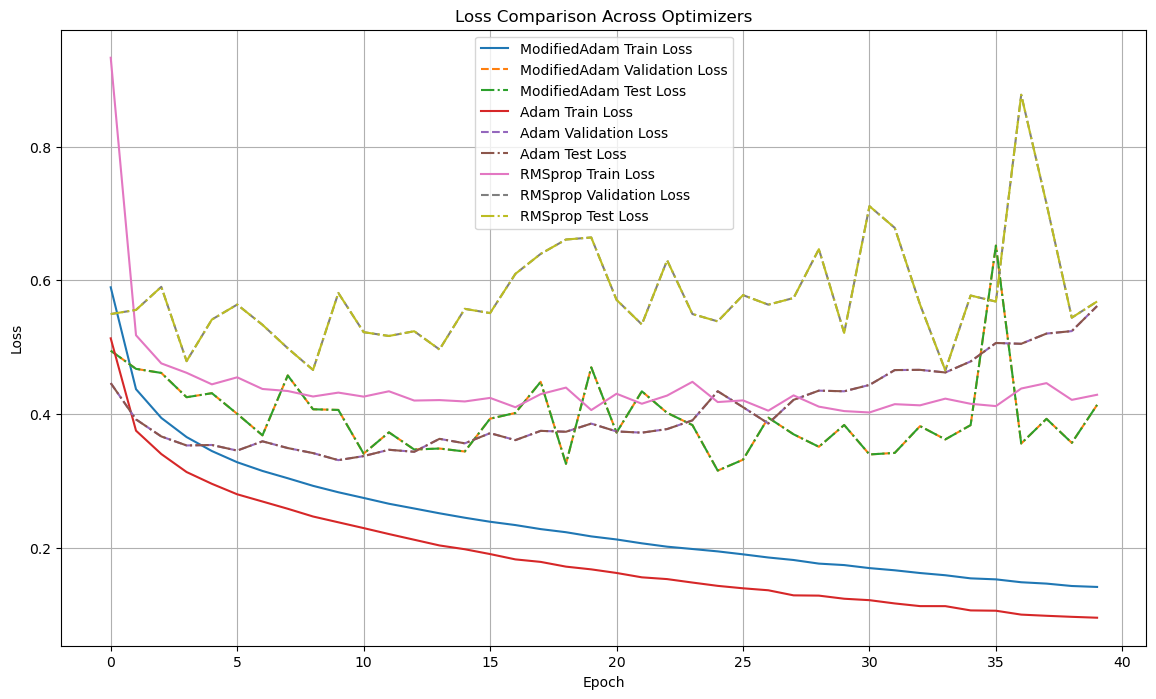

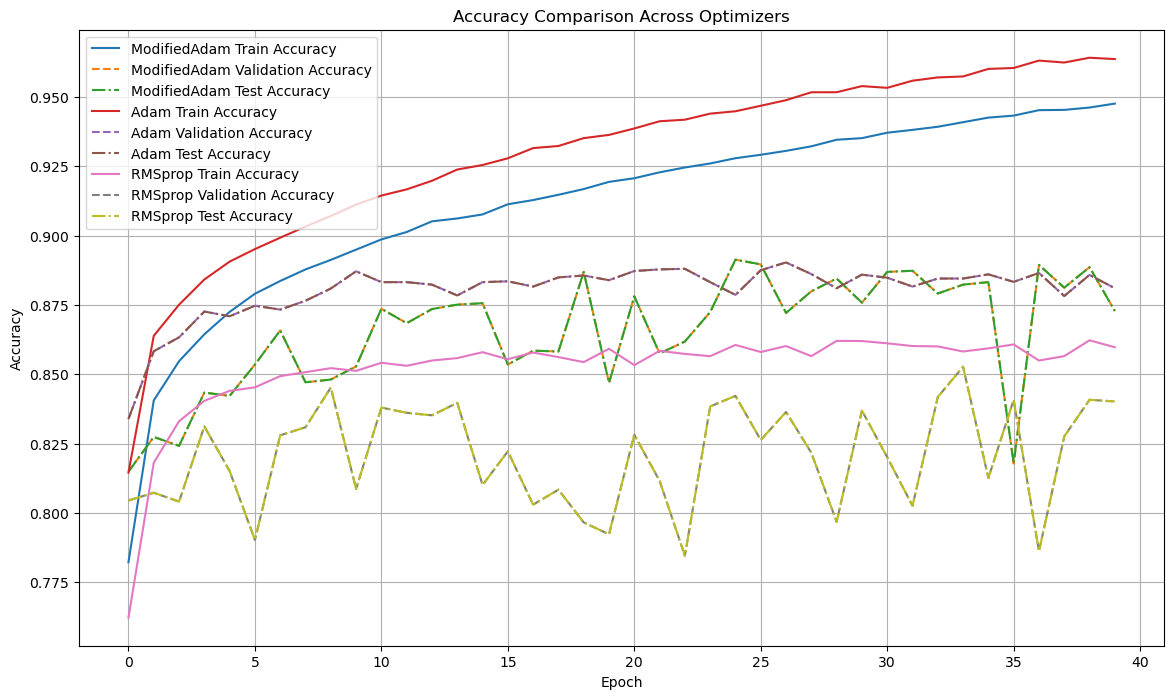

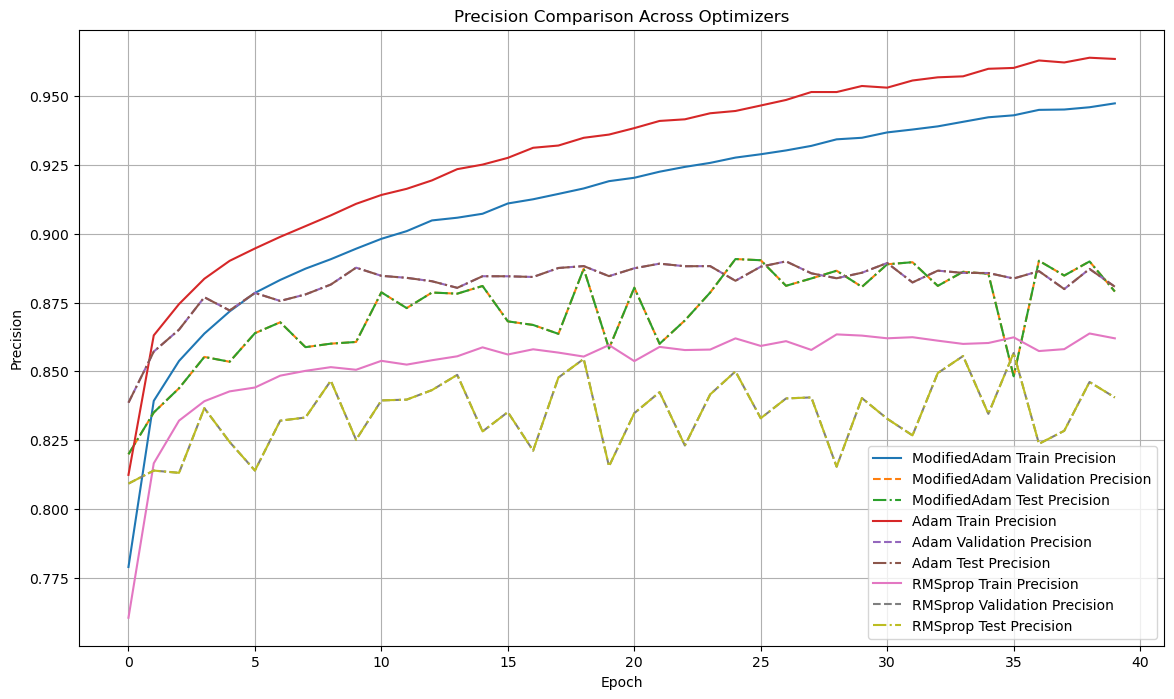

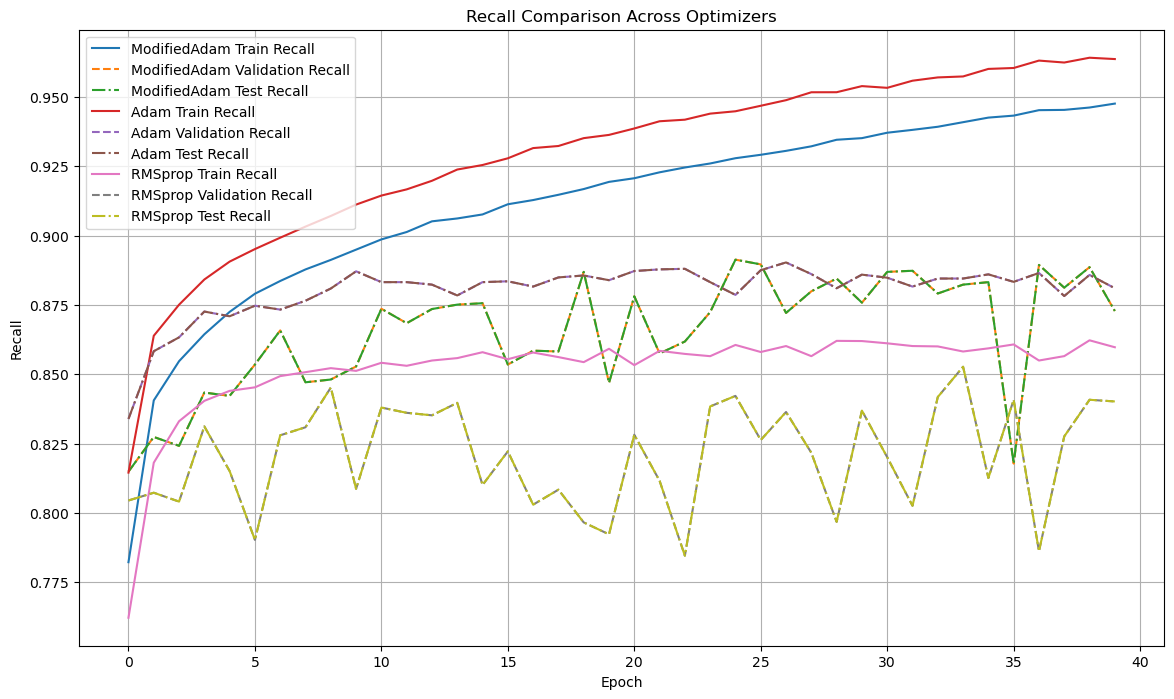

In [ ]:
##-------------------------------------------##
##                 Plotting                  ##
##-------------------------------------------##

# Extract Optimizer Names
optimizers = list(results.keys())

# Plot Configuration
metrics_to_plot = {
    'Loss': ['train_loss', 'val_loss', 'test_loss'],
    'Accuracy': ['train_accuracy', 'val_accuracy', 'test_accuracy'],
    'Precision': ['train_precision', 'val_precision', 'test_precision'],
    'Recall': ['train_recall', 'val_recall', 'test_recall']
}

# Create Subplots for Each Metric
for metric_name, metric_keys in metrics_to_plot.items():
    plt.figure(figsize=(14, 8))
    
    for opt_name in optimizers:
        # Plot Each Optimizer's Metric (Note: can choose which one you want to show)
        plt.plot(results[opt_name][metric_keys[0]], label=f"{opt_name} Train {metric_name}", linestyle='-')
        plt.plot(results[opt_name][metric_keys[1]], label=f"{opt_name} Validation {metric_name}", linestyle='--')
        plt.plot(results[opt_name][metric_keys[2]], label=f"{opt_name} Test {metric_name}", linestyle='-.')

    # Configure Plot Details 
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} Comparison Across Optimizers")
    plt.legend()
    plt.grid(True)
    plt.show()


In [31]:
for opt_name, metrics in results.items():
    max_train_accuracy = max(metrics['train_accuracy'])
    max_val_accuracy = max(metrics['val_accuracy'])
    max_test_accuracy = max(metrics['test_accuracy'])
    max_train_precision = max(metrics['train_precision'])
    max_val_precision = max(metrics['val_precision'])
    max_test_precision = max(metrics['test_precision'])
    max_train_recall = max(metrics['train_recall'])
    max_val_recall = max(metrics['val_recall'])
    max_test_recall = max(metrics['test_recall'])
    print(f"{opt_name} - Max Training Accuracy: {max_train_accuracy:.4f}, Max Validation Accuracy: {max_val_accuracy:.4f}, Max Test Accuracy: {max_test_accuracy:.4f}")
    print(f"{opt_name} - Max Training Precision: {max_train_precision:.4f}, Max Validation Precision: {max_val_precision:.4f}, Max Test Precision: {max_test_precision:.4f}")
    print(f"{opt_name} - Max Training Recall: {max_train_recall:.4f}, Max Validation Recall: {max_val_recall:.4f}, Max Test Recall: {max_test_recall:.4f}")


ModifiedAdam - Max Training Accuracy: 0.9476, Max Validation Accuracy: 0.8913, Max Test Accuracy: 0.8913
ModifiedAdam - Max Training Precision: 0.9474, Max Validation Precision: 0.8908, Max Test Precision: 0.8908
ModifiedAdam - Max Training Recall: 0.9476, Max Validation Recall: 0.8913, Max Test Recall: 0.8913
Adam - Max Training Accuracy: 0.9641, Max Validation Accuracy: 0.8903, Max Test Accuracy: 0.8903
Adam - Max Training Precision: 0.9640, Max Validation Precision: 0.8900, Max Test Precision: 0.8900
Adam - Max Training Recall: 0.9641, Max Validation Recall: 0.8903, Max Test Recall: 0.8903
RMSprop - Max Training Accuracy: 0.8622, Max Validation Accuracy: 0.8527, Max Test Accuracy: 0.8527
RMSprop - Max Training Precision: 0.8638, Max Validation Precision: 0.8567, Max Test Precision: 0.8567
RMSprop - Max Training Recall: 0.8622, Max Validation Recall: 0.8527, Max Test Recall: 0.8527
